In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/keras-model/keras/default/1/coastline_unet_model_s2_256_adapt.keras
/kaggle/input/code-file/network.py
/kaggle/input/balanced-ds/FinalDataset/images/Image_21_water_aug4_row6820_col3740.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_15_land_aug2_row8580_col2200.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_15_mixed_aug3_row6600_col9460.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_10_mixed_aug1_row1540_col9900.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_15_land_aug4_row7260_col4840.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_1_mixed_aug0_row6160_col5500.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_20_mixed_aug0_row2860_col0.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_20_mixed_aug2_row7260_col9240.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_1_mixed_aug0_row2640_col8800.jp2
/kaggle/input/balanced-ds/FinalDataset/images/Image_10_mixed_aug0_row6600_col2640.jp2
/kaggle/input/balanced-ds/Fina

In [3]:
# --- Imports ---
import tensorflow as tf
import numpy as np
import random
import os
import glob
from tqdm.notebook import tqdm
import rasterio
import math
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# --- 1. Setup & Configuration ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# --- Dataset Path ---
BASE_DATA_PATH = '/kaggle/input/balanced-ds/FinalDataset' 

IMAGES_DIR = os.path.join(BASE_DATA_PATH, 'images')
MASKS_DIR = os.path.join(BASE_DATA_PATH, 'masks')

# --- Image Dimensions ---
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 12

# --- Training Configuration ---
BATCH_SIZE = 8
BUFFER_SIZE = 1000
EPOCHS = 50
NUM_ADAPT_BATCHES = 500

# --- Model Checkpoint Path ---
MODEL_CHECKPOINT_PATH = '/kaggle/working/coastline_unet_model_s2_adapt.keras'
TENSORBOARD_LOG_DIR = '/kaggle/working/logs_coastline_s2_adapt'

# --- 2. Data Loading & Splitting ---
def get_all_file_paths(images_dir, masks_dir):
    image_files = sorted(glob.glob(os.path.join(images_dir, '*.jp2')))
    mask_files = sorted(glob.glob(os.path.join(masks_dir, '*.png')))
    
    if len(image_files) != len(mask_files):
        raise ValueError("Mismatch between number of images and masks!")
    return image_files, mask_files

print("Loading file paths...")
all_image_files, all_mask_files = get_all_file_paths(IMAGES_DIR, MASKS_DIR)

# --- Train/Validation Split (80:20) ---
print("Splitting dataset into train and validation (80:20)...")
train_img_files, val_img_files, train_mask_files, val_mask_files = train_test_split(
    all_image_files, all_mask_files, test_size=0.2, random_state=SEED
)

print(f"Training images: {len(train_img_files)}")
print(f"Validation images: {len(val_img_files)}")

# --- 3. Data Preprocessing Functions ---
@tf.function
def parse_image_mask(img_path, mask_path):
    def read_jp2(path):
        path = path.numpy().decode('utf-8')
        with rasterio.open(path) as img_ds:
            img = img_ds.read().astype(np.float32)  # (channels, H, W)
            img = np.transpose(img, (1, 2, 0))  # (H, W, channels)
            return img

    img = tf.py_function(read_jp2, [img_path], tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.float32)
    mask = tf.cast(mask > 127.0, tf.float32)

    return img, mask

def create_tf_dataset(image_files, mask_files, batch_size, shuffle=False, buffer_size=1000):
    dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(parse_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# --- 4. Create Datasets ---
print("Creating datasets...")
train_dataset = create_tf_dataset(train_img_files, train_mask_files, BATCH_SIZE, shuffle=True, buffer_size=BUFFER_SIZE)
val_dataset = create_tf_dataset(val_img_files, val_mask_files, BATCH_SIZE)

num_train_samples = len(train_img_files)
num_val_samples = len(val_img_files)
steps_per_epoch = math.ceil(num_train_samples / BATCH_SIZE)
validation_steps = math.ceil(num_val_samples / BATCH_SIZE)

# --- 5. Normalize the Data ---
print("Adapting normalization layer...")
normalization_layer = tf.keras.layers.Normalization(axis=-1)
adapt_dataset = train_dataset.map(lambda img, mask: img).take(NUM_ADAPT_BATCHES)
normalization_layer.adapt(adapt_dataset)

# --- 6. U-Net Model ---
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, activation="relu", kernel_initializer="he_normal", padding="same")(x)
    return x

def upsample_block(inputs, skip, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, skip])
    x = conv_block(concat, num_filters)
    return x

def build_unet(input_shape, norm_layer):
    inputs = tf.keras.layers.Input(input_shape)
    s = norm_layer(inputs)

    # Encoder
    c1 = conv_block(s, 16); p1 = tf.keras.layers.MaxPooling2D(2)(c1)
    c2 = conv_block(p1, 32); p2 = tf.keras.layers.MaxPooling2D(2)(c2)
    c3 = conv_block(p2, 64); p3 = tf.keras.layers.MaxPooling2D(2)(c3)
    c4 = conv_block(p3, 128); p4 = tf.keras.layers.MaxPooling2D(2)(c4)

    # Bridge
    c5 = conv_block(p4, 256)

    # Decoder
    c6 = upsample_block(c5, c4, 128)
    c7 = upsample_block(c6, c3, 64)
    c8 = upsample_block(c7, c2, 32)
    c9 = upsample_block(c8, c1, 16)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# --- Build and Compile Model ---
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_unet(input_shape, normalization_layer)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_pos = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_pos, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred_pos, axis=[1,2,3]) - intersection
    return tf.reduce_mean((intersection + smooth) / (union + smooth))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", iou_metric]
)
model.summary()

# --- 7. Callbacks ---
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_iou_metric', mode='max', restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(MODEL_CHECKPOINT_PATH, monitor='val_iou_metric', save_best_only=True, verbose=1, mode='max'),
    tf.keras.callbacks.TensorBoard(log_dir=TENSORBOARD_LOG_DIR),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
]

# --- 8. Train the Model ---
print("\nStarting training...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=callbacks
)
print(f"\nTraining completed. Best model saved at: {MODEL_CHECKPOINT_PATH}")


Loading file paths...
Splitting dataset into train and validation (80:20)...
Training images: 16800
Validation images: 4200
Creating datasets...


I0000 00:00:1745944559.051171      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745944559.051840      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Adapting normalization layer...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 12)   │             25 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │          1,744 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 1,942,426 (7.41 MB)

 Trainable params: 1,942,401 (7.41 MB)

 Non-trainable params: 25 (104.00 B)


Starting training...
Epoch 1/50


I0000 00:00:1745944716.534467     103 service.cc:148] XLA service 0x7fb848005210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745944716.535336     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745944716.535356     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745944718.001734     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745944734.263078     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9144 - iou_metric: 0.5451 - loss: 0.2424
Epoch 1: val_iou_metric improved from -inf to 0.82354, saving model to /kaggle/working/coastline_unet_model_s2_adapt.keras
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 786s 361ms/step - accuracy: 0.9144 - iou_metric: 0.5451 - loss: 0.2424 - val_accuracy: 0.9291 - val_iou_metric: 0.8235 - val_loss: 0.1711 - learning_rate: 1.0000e-04
Epoch 2/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.0000e+00 - iou_metric: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9318 - iou_metric: 0.8002 - loss: 0.1713
Epoch 3: val_iou_metric improved from 0.82354 to 0.82939, saving model to /kaggle/working/coastline_unet_model_s2_adapt.keras
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 667s 318ms/step - accuracy: 0.9318 - iou_metric: 0.8002 - loss: 0.1713 - val_accuracy: 0.9312 - val_iou_metric: 0.8294 - val_loss: 0.1690 - learning_rate: 1.0000e

I0000 00:00:1746036116.712180      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746036116.712983      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Model loaded successfully.


I0000 00:00:1746036120.992016     105 service.cc:148] XLA service 0x7f5f74003b40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746036120.994015     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746036120.994036     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746036121.240707     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746036124.413013     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


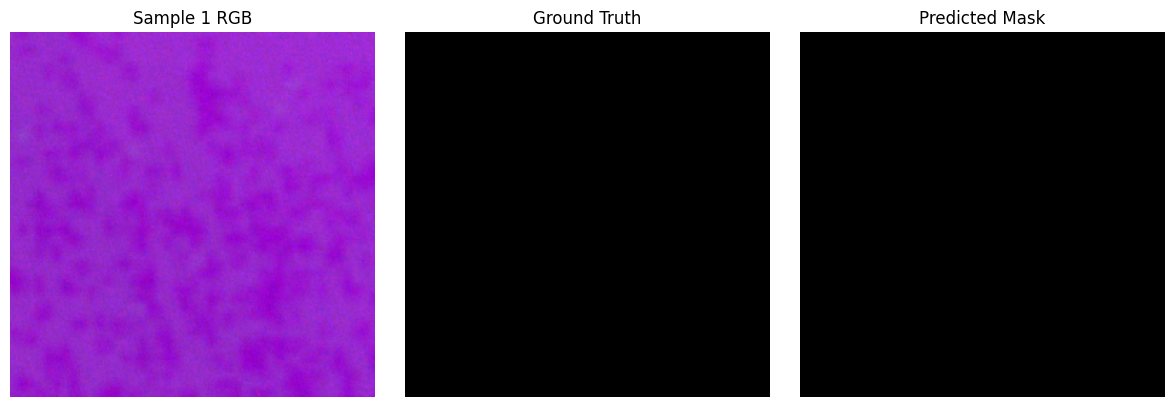

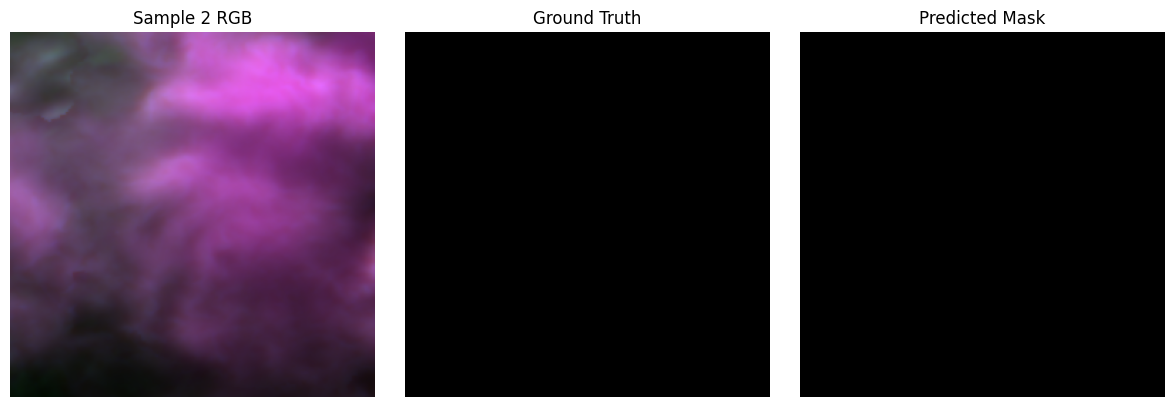

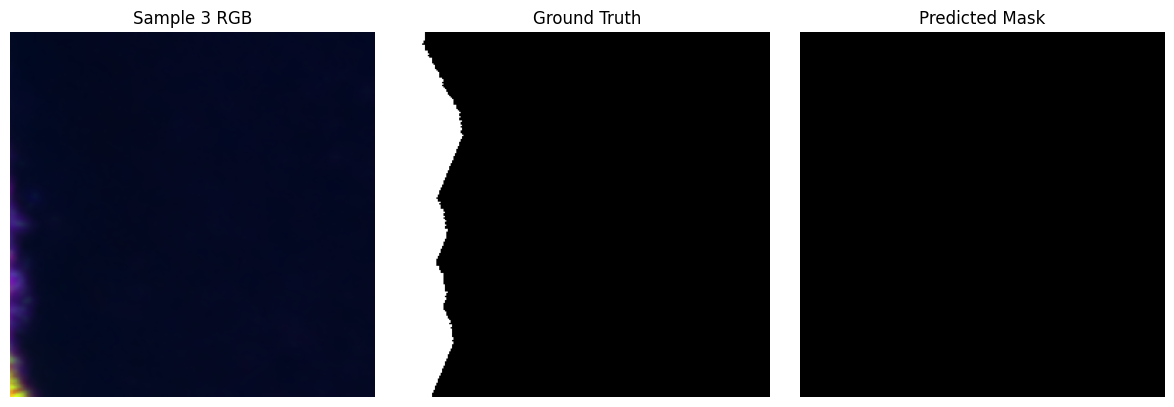

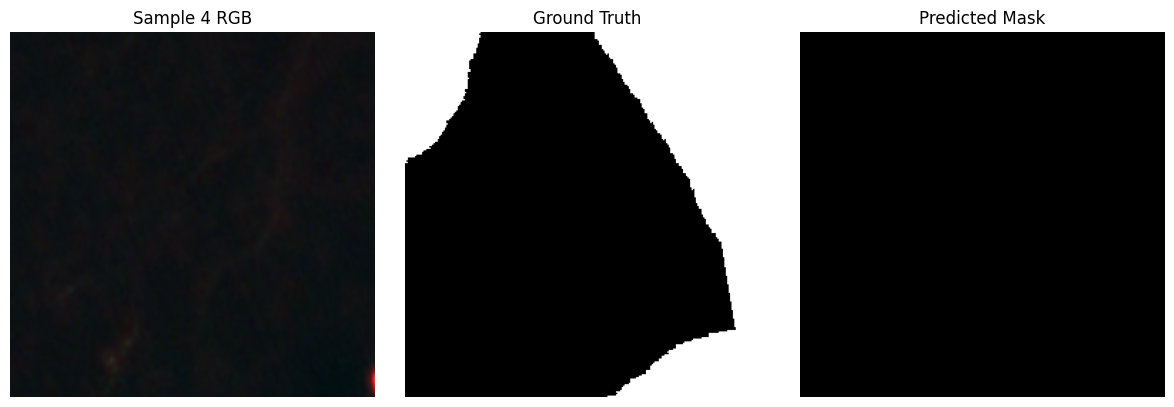

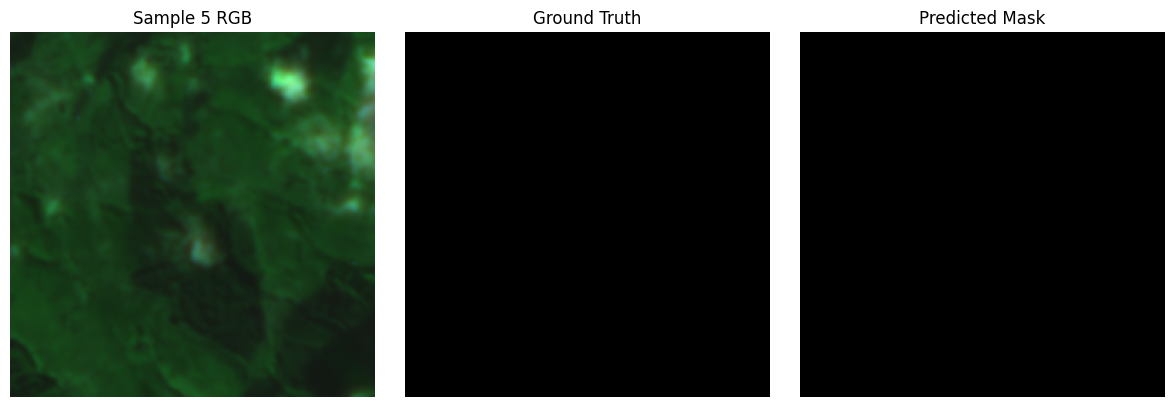

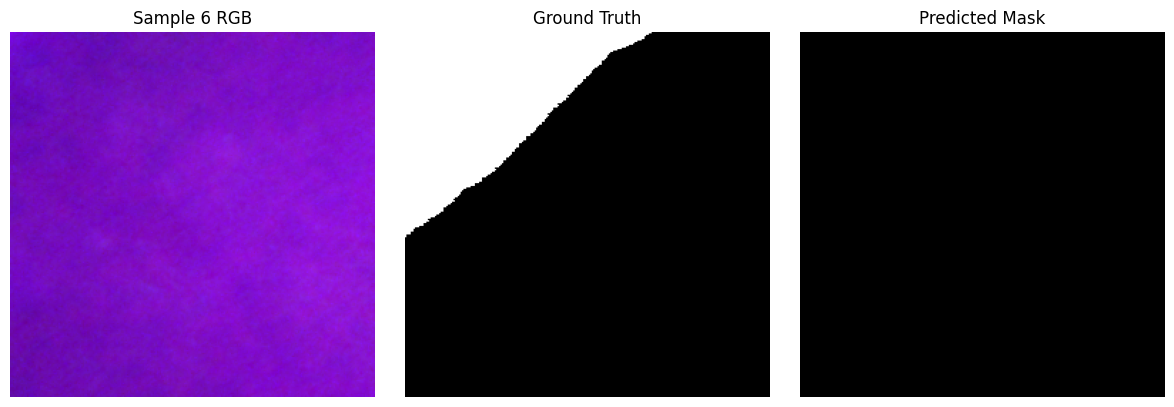

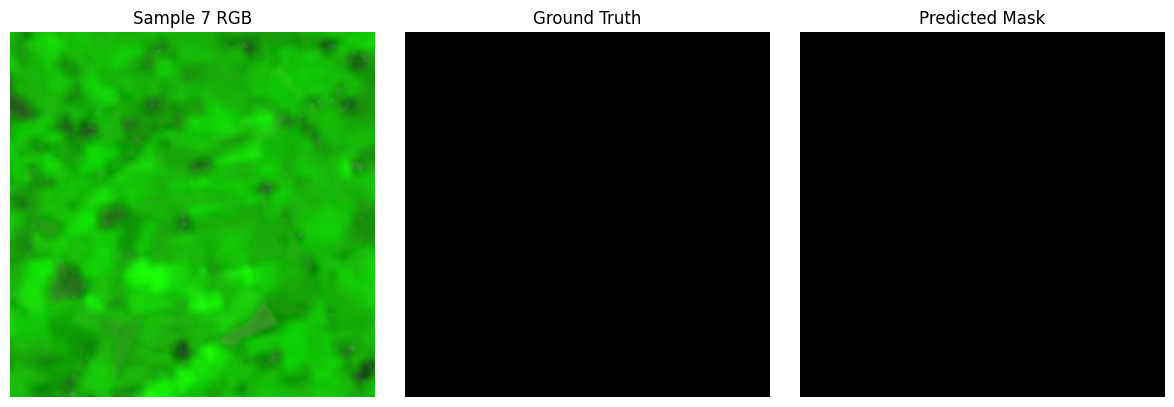

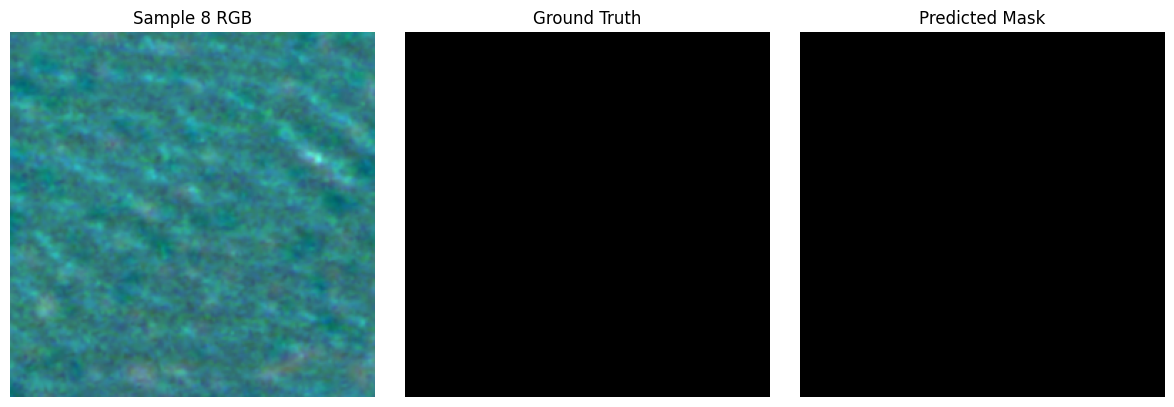

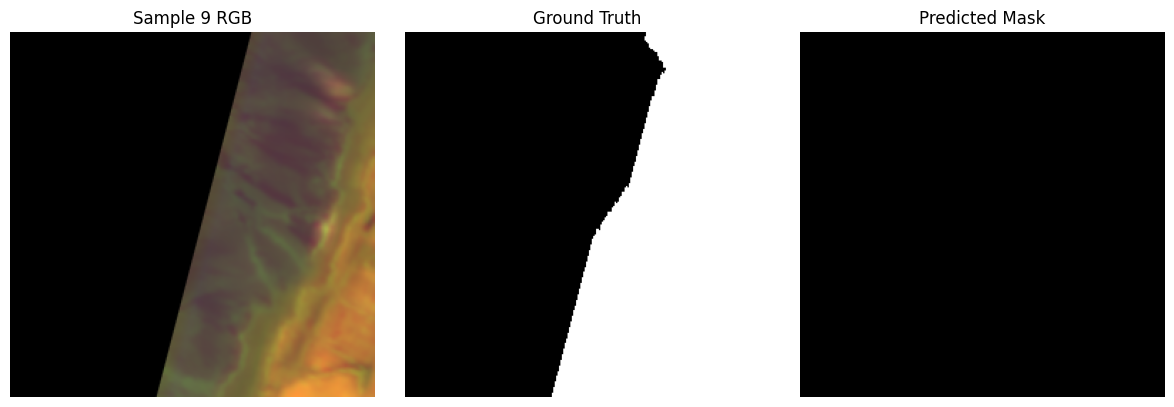

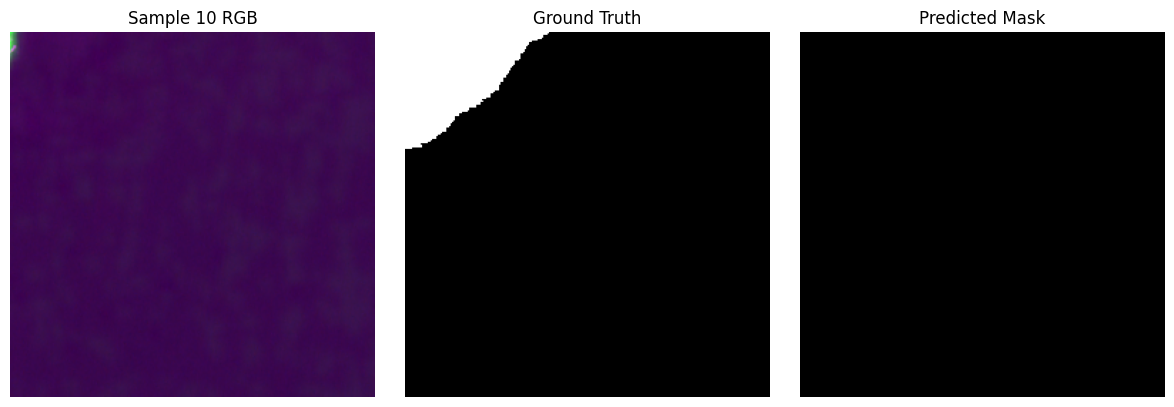

In [5]:
"""
Visualize Predictions from U-Net Model on 10 Validation Samples
"""

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import rasterio
from PIL import Image
import random

# --- Config ---
MODEL_PATH = '/kaggle/input/unet_model/tensorflow2/default/1/coastline_unet_model_s2_adapt.keras'
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 12
NUM_SAMPLES = 10
VAL_IMAGES_DIR = '/kaggle/input/balanced-ds/FinalDataset/images'
VAL_MASKS_DIR = '/kaggle/input/balanced-ds/FinalDataset/masks'

# --- Load trained model (compile=False for inference only) ---
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully.")

# --- Helper Functions ---
def read_jp2(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32).transpose(1, 2, 0)
        return img / 10000.0  # Normalize

def read_mask(path):
    mask = np.array(Image.open(path)).astype(np.float32)
    return (mask > 127).astype(np.float32)

def show_sample(img, mask, pred, title=""):
    rgb = img[:, :, [3, 2, 1]]  # RGB bands
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title(f"{title} RGB")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Load file paths ---
imagePaths = sorted([os.path.join(VAL_IMAGES_DIR, f) for f in os.listdir(VAL_IMAGES_DIR) if f.endswith('.jp2')])
maskPaths = sorted([os.path.join(VAL_MASKS_DIR, f.replace('.jp2', '.png')) for f in os.listdir(VAL_IMAGES_DIR)])

# --- Random sample indices ---
sampleIndices = random.sample(range(len(imagePaths)), min(NUM_SAMPLES, len(imagePaths)))

# --- Predict and show ---
for i, idx in enumerate(sampleIndices):
    img = read_jp2(imagePaths[idx])
    mask = read_mask(maskPaths[idx])
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
    predBinary = (pred > 0.5).astype(np.float32).squeeze()

    show_sample(img, mask, predBinary, title=f"Sample {i+1}")

In [9]:
# --- Imports ---
import tensorflow as tf
import numpy as np
import os
import glob
import rasterio
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score
from tqdm import tqdm

# --- Paths & Config ---
MODEL_PATH = '/kaggle/input/unet_model/tensorflow2/default/1/coastline_unet_model_s2_adapt.keras'
VAL_IMAGES_DIR = '/kaggle/input/validation-2/validation/images'
VAL_MASKS_DIR = '/kaggle/input/validation-2/validation/masks'
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 12

# --- Load Model ---
model = tf.keras.models.load_model(MODEL_PATH, compile=False)
print("✅ Model loaded.")

# --- Helper Functions ---
def read_jp2(path):
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32).transpose(1, 2, 0)
        return img / 10000.0  # Normalize

def read_mask(path):
    mask = np.array(Image.open(path)).astype(np.float32)
    return (mask > 127).astype(np.uint8)

# --- Collect file paths ---
imagePaths = sorted([os.path.join(VAL_IMAGES_DIR, f) for f in os.listdir(VAL_IMAGES_DIR) if f.endswith('.jp2')])
maskPaths = sorted([os.path.join(VAL_MASKS_DIR, f.replace('.jp2', '.png')) for f in os.listdir(VAL_IMAGES_DIR)])

# --- Evaluate ---
yTrueTotal, yPredTotal = [], []

print(f"Running evaluation on {len(imagePaths)} validation images...")
for imgPath, maskPath in tqdm(zip(imagePaths, maskPaths), total=len(imagePaths)):
    img = read_jp2(imgPath)
    mask = read_mask(maskPath)

    inputTensor = np.expand_dims(img, axis=0)  # shape: (1, 256, 256, 12)
    pred = model.predict(inputTensor, verbose=0)[0]
    predBinary = (pred > 0.5).astype(np.uint8).squeeze()

    yTrueTotal.extend(mask.flatten())
    yPredTotal.extend(predBinary.flatten())

# --- Metrics ---
yTrueTotal = np.array(yTrueTotal)
yPredTotal = np.array(yPredTotal)

precision = precision_score(yTrueTotal, yPredTotal)
recall = recall_score(yTrueTotal, yPredTotal)
f1 = f1_score(yTrueTotal, yPredTotal)
iou = jaccard_score(yTrueTotal, yPredTotal)
acc = accuracy_score(yTrueTotal, yPredTotal)

print("\n📊 Evaluation Metrics:")
print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall   : {recall:.4f}")
print(f"✅ F1 Score : {f1:.4f}")
print(f"✅ IoU      : {iou:.4f}")


✅ Model loaded.
Running evaluation on 20 validation images...


100%|██████████| 20/20 [00:04<00:00,  4.74it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



📊 Evaluation Metrics:
✅ Accuracy : 0.6813
✅ Precision: 0.0000
✅ Recall   : 0.0000
✅ F1 Score : 0.0000
✅ IoU      : 0.0000


In [ ]:
# --- Imports ---
import tensorflow as tf
import numpy as np
import random
import os
import glob
import rasterio
from sklearn.model_selection import train_test_split

# --- 1. Configuration ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 12
BATCH_SIZE = 8
EPOCHS = 25
BUFFER_SIZE = 1000
NUM_ADAPT_BATCHES = 500

BASE_PATH = '/kaggle/input/balanced-ds/FinalDataset'
MODEL_SAVE_PATH = '/kaggle/working/unet_bce_dice.keras'

imagesDir = os.path.join(BASE_PATH, 'images')
masksDir = os.path.join(BASE_PATH, 'masks')

# --- 2. Load & Split Data ---
def get_paths(imgDir, mskDir):
    imgs = sorted(glob.glob(os.path.join(imgDir, '*.jp2')))
    msks = sorted(glob.glob(os.path.join(mskDir, '*.png')))
    return imgs, msks

allImages, allMasks = get_paths(imagesDir, masksDir)
trainImgs, valImgs, trainMsks, valMsks = train_test_split(allImages, allMasks, test_size=0.2, random_state=SEED)

# --- 3. TF Dataset ---
@tf.function
def parse_pair(imgPath, maskPath):
    def read_img(path):
        path = path.numpy().decode()
        with rasterio.open(path) as src:
            arr = src.read().astype(np.float32).transpose(1, 2, 0)
            return arr
    img = tf.py_function(read_img, [imgPath], tf.float32)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    mask = tf.io.read_file(maskPath)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    mask = tf.cast(mask > 127, tf.float32)
    return img, mask

def create_dataset(imgList, maskList, batchSize, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((imgList, maskList))
    if shuffle:
        ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.map(parse_pair, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batchSize).prefetch(tf.data.AUTOTUNE)

trainDs = create_dataset(trainImgs, trainMsks, BATCH_SIZE, shuffle=True)
valDs = create_dataset(valImgs, valMsks, BATCH_SIZE)

# --- 4. Normalization Layer ---
normLayer = tf.keras.layers.Normalization()
normLayer.adapt(trainDs.map(lambda x, y: x).take(NUM_ADAPT_BATCHES))

# --- 5. U-Net Model ---
def conv_block(x, f):
    x = tf.keras.layers.Conv2D(f, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(f, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def up_block(x, skip, f):
    x = tf.keras.layers.Conv2DTranspose(f, 2, strides=2, padding='same')(x)
    x = tf.keras.layers.Concatenate()([x, skip])
    return conv_block(x, f)

def build_unet(inputShape):
    inputs = tf.keras.Input(inputShape)
    x = normLayer(inputs)

    # Encoder
    c1 = conv_block(x, 16); p1 = tf.keras.layers.MaxPooling2D(2)(c1)
    c2 = conv_block(p1, 32); p2 = tf.keras.layers.MaxPooling2D(2)(c2)
    c3 = conv_block(p2, 64); p3 = tf.keras.layers.MaxPooling2D(2)(c3)
    c4 = conv_block(p3, 128); p4 = tf.keras.layers.MaxPooling2D(2)(c4)

    # Bridge
    c5 = conv_block(p4, 256)

    # Decoder
    u6 = up_block(c5, c4, 128)
    u7 = up_block(u6, c3, 64)
    u8 = up_block(u7, c2, 32)
    u9 = up_block(u8, c1, 16)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(u9)
    return tf.keras.Model(inputs, outputs)

model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.summary()

# --- 6. BCE + Dice Loss ---
def dice_loss(yTrue, yPred, smooth=1e-6):
    yPred = tf.cast(yPred > 0.5, tf.float32)
    intersection = tf.reduce_sum(yTrue * yPred, axis=[1, 2, 3])
    union = tf.reduce_sum(yTrue + yPred, axis=[1, 2, 3])
    return 1 - tf.reduce_mean((2. * intersection + smooth) / (union + smooth))

def bce_dice_loss(yTrue, yPred):
    bce = tf.keras.losses.binary_crossentropy(yTrue, yPred)
    return bce + dice_loss(yTrue, yPred)

# --- 7. Compile Model ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy']
)

# --- 8. Callbacks ---
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True, mode='max'),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# --- 9. Train Model ---
model.fit(
    trainDs,
    validation_data=valDs,
    epochs=EPOCHS,
    callbacks=callbacks
)
print(f"\n✅ Training complete. Best model saved to: {MODEL_SAVE_PATH}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 12)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 12)   │             25 │ input_layer[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │          1,744 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 1,942,426 (7.41 MB)

 Trainable params: 1,942,401 (7.41 MB)

 Non-trainable params: 25 (104.00 B)

Epoch 1/25
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 941s 435ms/step - accuracy: 0.9144 - loss: 0.6691 - val_accuracy: 0.9290 - val_loss: 0.3235 - learning_rate: 1.0000e-04
Epoch 2/25
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 720s 343ms/step - accuracy: 0.9318 - loss: 0.3483 - val_accuracy: 0.9311 - val_loss: 0.3167 - learning_rate: 1.0000e-04
Epoch 3/25
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 717s 341ms/step - accuracy: 0.9356 - loss: 0.3177 - val_accuracy: 0.9412 - val_loss: 0.2826 - learning_rate: 1.0000e-04
Epoch 4/25
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 721s 343ms/step - accuracy: 0.9395 - loss: 0.3007 - val_accuracy: 0.9434 - val_loss: 0.2716 - learning_rate: 1.0000e-04
Epoch 5/25
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 716s 341ms/step - accuracy: 0.9403 - loss: 0.2978 - val_accuracy: 0.9425 - val_loss: 0.2719 - learning_rate: 1.0000e-04
Epoch 6/25
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 719s 342ms/step - accuracy: 0.9412 - loss: 0.2921 - val_accuracy: 0.9428 - val_loss: 0.2668 - learning_rate: 1.0000e-04
Epoch 7/25
2100/2100 ━━━━━━━